In [44]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rakeshkapilavai/extrovert-vs-introvert-behavior-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/extrovert-vs-introvert-behavior-data


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
df = pd.read_csv(path + "/personality_dataset.csv")

#Dataset Cleaning

In [47]:
def clean(df):
    # Count rows with at least one null value
    null_rows = df.isnull().any(axis=1).sum()
    total_rows = df.shape[0]

    print(f"Percentage of rows with missing values: {100*null_rows/total_rows}")

    if (null_rows/total_rows <= 0.2):
      df.dropna(inplace=True)
      print("Dropped rows with missing values.")
    else:
        # Impute missing values (consider mean for int64/float64, consider mode for objects)
        for col in df.columns:
            if df[col].dtype in ['float64', 'int64']:
                df[col].fillna(df[col].mean(), inplace=True)
            else:
                df[col].fillna(df[col].mode()[0], inplace=True)
        print("Performed imputation (mean/mode) for missing values.")

    # Convert 'Yes'/'No' to boolean
    for col in df.select_dtypes(include='object').columns:
        unique_vals = df[col].dropna().unique()

        if set(unique_vals) == {'Yes', 'No'}:
            df[col] = df[col].map({'Yes': True, 'No': False})
            print(f"Converted column '{col}' to boolean.")

    # Drop duplicate rows
    df.drop_duplicates(inplace=True)

    # Handle cases like "  Yes", " Yes ", etc.
    df.columns = df.columns.str.strip()

    # Encode 'Introvert' as 1, 'Extrovert' as 0
    if 'Personality' in df.columns:
        df['Personality'] = df['Personality'].map({'Introvert': 1, 'Extrovert': 0})
        print("Encoded 'Personality' column")

    # Convert float64 and boolean into int64
    for column in df.columns:
        df[column] = df[column].astype('int64')

    return df

In [48]:
cleaned_df = clean(df)
cleaned_df.shape

Percentage of rows with missing values: 14.586206896551724
Dropped rows with missing values.
Converted column 'Stage_fear' to boolean.
Converted column 'Drained_after_socializing' to boolean.
Encoded 'Personality' column


(2098, 8)

In [49]:
cleaned_df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4,0,4,6,0,13,5,0
1,9,1,0,0,1,0,3,1
2,9,1,1,2,1,5,2,1
3,0,0,6,7,0,14,8,0
4,3,0,9,4,0,8,5,0


#Model Fitting

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, ConfusionMatrixDisplay

##Dataframe Splitting

In [51]:
def split_data(df, target_column='Personality', test_size=0.2, random_state=42):
    X = df.drop(columns=[target_column])
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

##Train Model

In [50]:
def train_model(X_train, y_train):
    model = LogisticRegression(solver='liblinear', class_weight='balanced')
    model.fit(X_train, y_train)
    return model

##Evaluate Model

In [56]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    return y_pred

##Confusion Matrix

In [60]:
def confusion_matrix(y_test, y_pred):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

##Execute Functions

Logistic Regression Accuracy: 0.9310
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       236
           1       0.91      0.94      0.92       184

    accuracy                           0.93       420
   macro avg       0.93      0.93      0.93       420
weighted avg       0.93      0.93      0.93       420



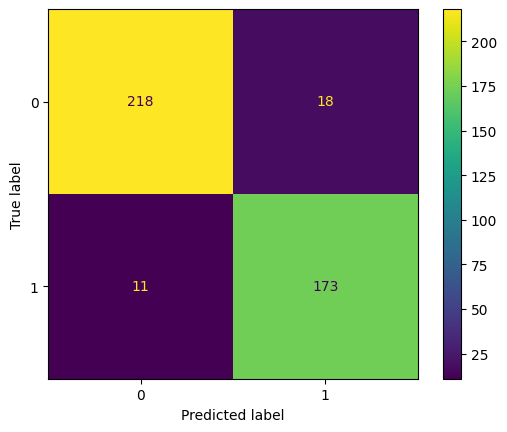

In [61]:
X_train, X_test, y_train, y_test = split_data(df)
model = train_model(X_train, y_train)
y_pred = evaluate_model(model, X_test, y_test)
confusion_matrix(y_test, y_pred)

#Save and Deploy Model

In [62]:
import joblib

def save_model(model, filename='modelV1.joblib'):
    joblib.dump(model, filename)
    print(f"Model saved to '{filename}'")

In [64]:
def load_model(filename='model.joblib'):
    model = joblib.load(filename)
    print(f"Model loaded from '{filename}'")
    return model

In [66]:
# Save current trained model
save_model(model)

# Load saved model
loaded_model = load_model('modelV1.joblib')

Model saved to 'modelV1.joblib'
Model loaded from 'modelV1.joblib'


In [71]:
df = pd.read_csv('/content/evaluation_dataset.csv')
df_new = clean(df)
X_train, X_test, y_train, y_test = split_data(df_new)
y_pred = evaluate_model(loaded_model, X_test, y_test)

Percentage of rows with missing values: 16.03448275862069
Dropped rows with missing values.
Converted column 'Stage_fear' to boolean.
Converted column 'Drained_after_socializing' to boolean.
Encoded 'Personality' column
Logistic Regression Accuracy: 0.9158
              precision    recall  f1-score   support

           0       0.95      0.91      0.93        58
           1       0.87      0.92      0.89        37

    accuracy                           0.92        95
   macro avg       0.91      0.92      0.91        95
weighted avg       0.92      0.92      0.92        95

